# Plot syllable waveform derivatives

In [2]:
import toml
import numba
import random
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import signal
from os.path import join
from rl_analysis import ANALYSIS_CONFIG
from rl_analysis.behavior.moseq import syll_onset
from rl_analysis.plotting import (
    fg,
    setup_plotting_env,
    clean_ticks,
    save_factory,
    add_legend,
    plot_bootstrap_matrix,
)
from rl_analysis.io.df import dlight_exclude_toml, NONSYLL_COLS
from toolz import partial
from tqdm.contrib.concurrent import process_map
from rl_analysis.photometry.windowing import window_trials_as_mtx
from rl_analysis.bootstraps import bootstrap_ci

warnings.simplefilter("ignore")
numba.set_num_threads(2)  # set to # of cores on computer
random.seed(0)

In [3]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

setup_plotting_env()

saver = save_factory(join(config['figures']['dir_wg'], 'fig-01'), tight_layout=False)

## Loading and setup

In [4]:
def compute_waveforms(df, dlight_key, shuffle=True):
    inds = np.where(df["offline onset"])[0]
    if shuffle:
        inds = inds + np.array(list(map(lambda v: random.randint(-60, 60), range(len(inds)))))
    time, trials = window_trials_as_mtx(
        df, inds, dlight_key, truncation_window=(-1.5, 1.5), zscore_signal=True
    )
    out = pd.Series(np.nanmean(trials, axis=0), index=time)
    return out


def dlight_filter(ser):
    soscoeffs = signal.bessel(1, 1 / (30 / 2.0), btype="high", output="sos")
    sig = ser.dropna()
    new_ser = pd.Series(index=ser.index)
    new_ser.loc[sig.index] = signal.sosfiltfilt(soscoeffs, sig)
    return new_ser


def compute_shuffle(i, df, dlight_key):
    df = df.copy()
    result = compute_waveforms(df, dlight_key, shuffle=True)
    return result

In [5]:
use_dct = dlight_exclude_toml(
    "/home/wg41/reinforcement_data/_proc_photometry_dlight/dlight_photometry_processed_full.toml",
    **config["dlight_common"]
)

In [6]:
# read in dataframe
df = pd.read_parquet(
    config['intermediate_results']['dlight_public'],
    filters=[("uuid", "in", list(use_dct)), ("area", "=", "dls")],
)

# remove post-stim sessions
df = df[~df['session_number'].isin([3, 4])]
# drop non-syllable and non-dLight columns
df = df.drop(columns=NONSYLL_COLS)
df = df.sort_index()

# compute syllable onsets
df['offline onset'] = False
df.loc[df.index[syll_onset(df['predicted_syllable (offline)'])], 'offline onset'] = True

df["dlight filtered"] = df.groupby("uuid", sort=False, observed=True)[
    "signal_reref_dff_z"
].transform(dlight_filter)

## Compute derivative

In [7]:
df["d_signal_reref_dff_z_03"] = df.groupby("uuid", observed=True, sort=False)[
    "dlight filtered"
].transform(lambda v: v.diff(3) / 3)

### Compute shuffle then z-score

In [8]:
n_shuffles = 1_000
syll_key = "predicted_syllable (offline)"
shuff_key = "shuff_dlight"

dlight_key = "d_signal_reref_dff_z_03"

In [ ]:
results = process_map(
    partial(compute_shuffle, df=df[[syll_key, dlight_key, "offline onset"]], dlight_key=dlight_key),
    range(n_shuffles),
    max_workers=7,  # set to # of cores on computer
)
shuff_waveforms = pd.DataFrame(results)

In [8]:
joblib.dump(
    shuff_waveforms,
    "/home/wg41/reinforcement_data/processed-dfs/fig1-highpass-waveform-derivative-shuffles.p",
)

['/home/wg41/reinforcement_data/processed-dfs/fig1-highpass-waveform-derivative-shuffles.p']

In [10]:
# uncomment to load pre-computed shuffles
# shuff_waveforms = joblib.load(
#     "/home/wg41/reinforcement_data/processed-dfs/fig1-highpass-waveform-derivative-shuffles.p"
# )

In [11]:
inds = np.where(df["offline onset"])[0]
time, mtx = window_trials_as_mtx(
    df, inds, dlight_key, truncation_window=(-1.5, 1.5), zscore_signal=True
)
z_waveforms = (mtx - np.nanmean(shuff_waveforms, axis=0, keepdims=True)) / np.nanstd(
    shuff_waveforms, axis=0, keepdims=True
)

In [12]:
boots = bootstrap_ci(z_waveforms)

In [13]:
z_shuff_waveforms = (
    shuff_waveforms.to_numpy() - np.nanmean(shuff_waveforms, axis=0, keepdims=True)
) / np.nanstd(shuff_waveforms, axis=0, keepdims=True)

## Panel - onset aligned syllable waveform derivatives

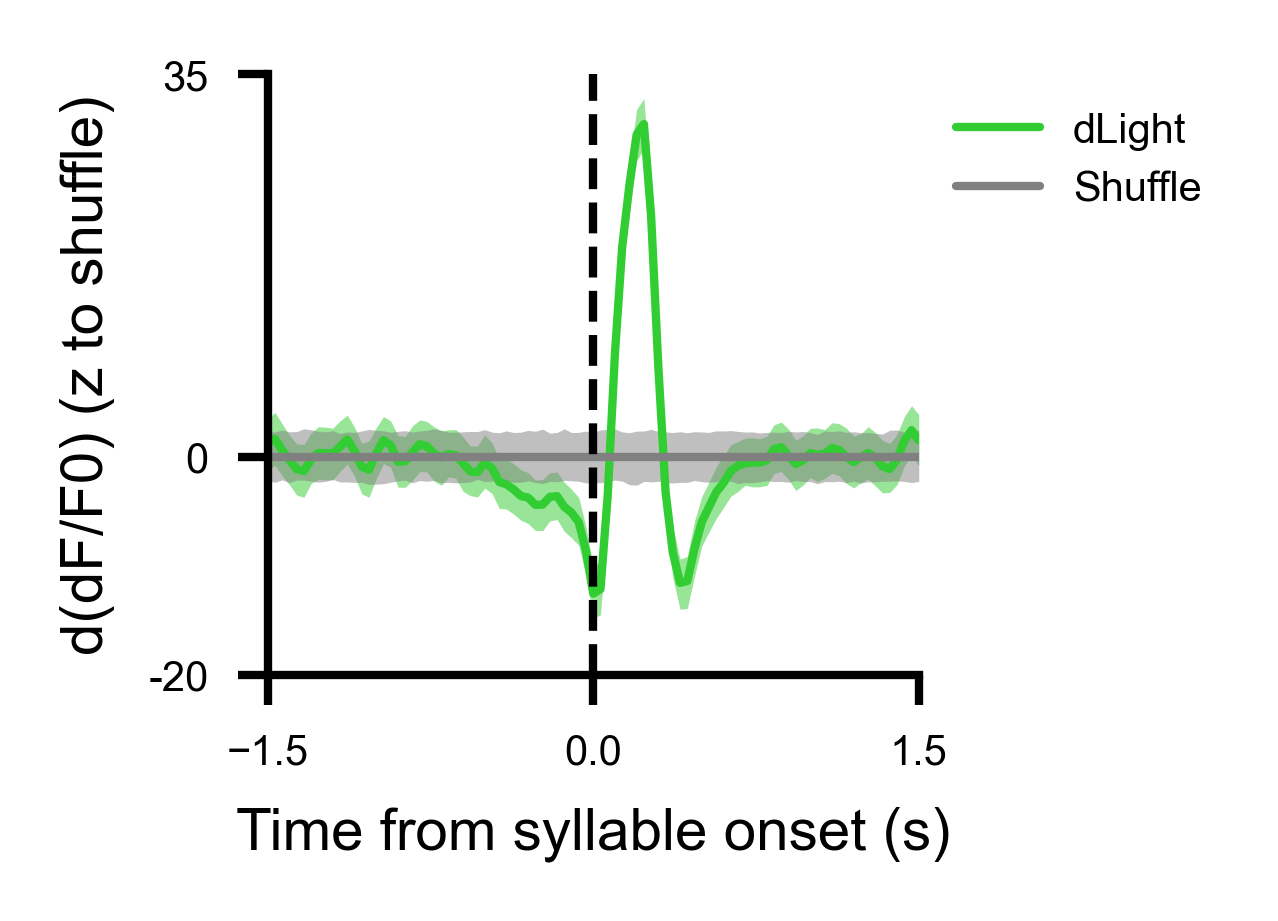

In [14]:
fig = fg(1.4, 1.3)
fig.dpi = 300
ax = plot_bootstrap_matrix(time, boots, color='limegreen', label="dLight")
ax = plot_bootstrap_matrix(time, z_shuff_waveforms, color='gray', ax=ax, label="Shuffle")
ax.axvline(0, ls='--', lw=1, c='k')
ax.set(
    xlim=(-1.5, 1.5),
    xticks=[-1.5, 0, 1.5],
    ylabel="d(dF/F0) (z to shuffle)",
    xlabel="Time from syllable onset (s)",
    ylim=(-20, 35)
)
clean_ticks(ax, axis='y', zero_symmetry=False, dtype=int)
add_legend(ax)
sns.despine()
# saver(fig, 'highpass-dlight-derivative', tight_layout=False);